# Descrição de Atividade

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados foram eleitos nas eleições de 2014. De forma específica:

 1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)
 2. Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
 3. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)
 4. Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
 5. Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
 6. Experimente outras estratégias de ensembles (e.g. Stacking).
 7. Experimente balancear as classes,  caso estejam desbalanceadas.

Os dados estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data (Links para um site externo)Links para um site externo

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.


### Descrição dos dados:

Os dados utilizados correspondem aos das eleições de Deputado Federal nos anos de 2006, 2010 e 2014. Estão dividos nas seguintes colunas:

* **ano**: Ano da eleição;
* **sequencial_candidato**: O identificador do candidato. Corresponde à coluna Id do arquivo de submissão;
* **nome**: Nome do candidato;
* **uf**: Sigla do estado do candidato;
* **partido**: Partido do candidato;
* **quantidade_doacoes**: Número de doações que um candidato recebeu;
* **quantidade_doadores**: Numero de doadores que um candidato teve;
* **total_receita**: Total de receita de um candidato;
* **media_receita**: Média da receita de um candidato;
* **recursos_de_outros_candidatos.comites**: Total de receita proveniente de outros candidatos e comitês;
* **recursos_de_pessoas_fisicas**: Total de receita proveniente de pessoas físicas;
* **recursos_de_pessoas_juridicas**: Total de receita proveniente de pessoas juridicas;
* **recursos_proprios**:Total de receita proveniente dos próprios candidatos;
* **recursos_de_partido_politico**: Total de receita proveniente do partido do candidato;
* **quantidade_despesas**: Número de despesas que um candidato teve;
* **quantidade_fornecedores**: Número de fornecedores que um candidato teve;
* **total_despesa**: Total de depesa de um candidato;
* **media_despesa**: Média da despesa de um candidato;
* **cargo**: Cargo ao qual o candidato está concorrendo;
* **sexo**: Sexo do candidato;
* **grau**: Grau de escolaridade do candidato;
* **estado_civil**: Estado civil do candidato;
* **ocupacao**: Ocupação do candidato;
* **situacao**: Situação final do candidato. Corresponde à coluna **Predict** do arquivo de submissão;

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.externals.joblib import Parallel, delayed

from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter

import matplotlib.pyplot as plt

sns.set(style="ticks")

%matplotlib inline

## Load Data

In [2]:
train_df = pd.read_csv('../data/assignment_4/train.csv')
test_df = pd.read_csv('../data/assignment_4/test.csv')

data = pd.concat([train_df, test_df], sort=False)

data.set_index('sequencial_candidato', inplace=True, drop=True)

## Preprocess Data

In [3]:
data.drop(columns=['nome'], inplace=True)

In [4]:
qt = QuantileTransformer(random_state=2, output_distribution='normal')

skewed_features = ['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos.comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'recursos_de_partido_politico',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa']

data[skewed_features] = qt.fit_transform(X=data[skewed_features])

In [5]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}

data.replace(cleanup_nums, inplace=True)
data["grau"] = pd.to_numeric(data["grau"])

In [6]:
categorical_feats = [col for col in data.columns if not np.issubdtype(data[str(col)].dtype, np.number) and col not in ['nome', 'situacao']]

data = pd.get_dummies(data, columns=categorical_feats)
data.shape

(12214, 258)

## Split Data into Train and Test

In [7]:
data['situacao_dummy'] = data['situacao'].map({'eleito': 1, 'nao_eleito': 0})

train = data[(data.ano == 2006) | (data.ano == 2010)]
test = data[data.ano == 2014]

print(train.shape)
print(test.shape)

(7622, 259)
(4592, 259)


## Target Class Imbalancing

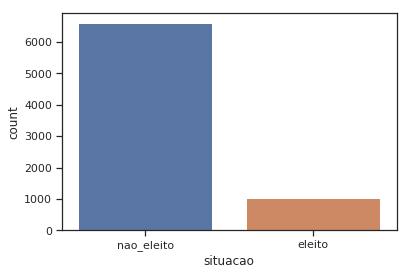

In [8]:
sns.countplot(x='situacao', data=train)

In [9]:
num_elected_candidates = train.situacao[train.situacao == 'eleito'].count()
num_not_elected_candidates = train.situacao[train.situacao == 'nao_eleito'].count()
total_candidates = train.shape[0]

print("Número de candidatos Eleitos: {}".format(num_elected_candidates))
print("Número de candidatos Não-Eleitos: {}".format(num_not_elected_candidates))
print("Total de candidatos: {}\n".format(total_candidates))

print("Proporção de candidatos eleitos: {:2.2%}".format((num_elected_candidates/total_candidates)))
print("Proporção de candidatos não-eleitos: {:2.2%}".format((num_not_elected_candidates/total_candidates)))

Número de candidatos Eleitos: 1026
Número de candidatos Não-Eleitos: 6596
Total de candidatos: 7622

Proporção de candidatos eleitos: 13.46%
Proporção de candidatos não-eleitos: 86.54%


A variável alvo **situacao** é bastante _desbalanceada_, em uma proporção de aproximadamente 1 eleito para cada 6 não-eleitos. Precisamente 13.46% dos candidatos foram eleitos, enquanto 86.54% não foram eleitos.

Esse desbalanceamento pode causar alguns efeitos colaterais na classificação feita pelo modelo preditor, tais como overfitting do modelo em relação à classe majoritária, o que prejudica a acurácia da predição, podendo causar até mesmo a interpretação incorreta dos resultados se o desbalanceamento não for endereçado corretamente.

Existem algumas práticas que podemos adotar para corrigir e lidar com esse desbalanceamento, a saber:

* Coleta de mais dados, que poderia rebalancear as classes, a depender da natureza do problema;
* Mudar a forma de amostragem do dataset, a qual pode estar gerando uma amostra desbalanceada, contudo o dataset não está desbalanceado;
* Usar alguma forma de gerar dados sintéticos como Synthetic Minority Over-sampling Technique [SMOTE](https://imbalanced-learn.org/en/stable/over_sampling.html#cbhk2002) e Adaptive Synthetic [ADASYN](https://imbalanced-learn.org/en/stable/over_sampling.html#hbgl2008);
* Incorporar algum modelo que tem uma forma de penalização para compensar o desbalanceamento de classes a exemplo de penalized-LDA e penalized-SVM.


Para essa atividade nós usaremos a técnica de geração de dados sintéticos SMOTE.

In [10]:
train.drop(['situacao'], axis=1, inplace=True)

X = train.loc[:, train.columns != 'situacao_dummy']
y = train.situacao_dummy

X_train, y_train = SMOTE().fit_resample(X, y)
print("SMOTE: {}".format(sorted(Counter(y_train).items())))

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


SMOTE: [(0.0, 6596), (1.0, 6596)]


## Split Train and Validation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train: {}".format(X_train.shape, y_train.shape))
print("Test: {}".format(X_test.shape, y_test.shape))

Train: (10553, 257)
Test: (2639, 257)


## Modelos

#### **_KNN (K-Nearest Neighbors)_**

cv_scores = []
neighbors = range(3, 20, 2)
neighbors = list(filter(lambda x: x % 2 != 0, neighbors))

def run_classisier(k):
    knr = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knr, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()

cv_scores = Parallel(n_jobs=-1, verbose=1)(delayed(run_classisier)(k) for k in neighbors)
   
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#### Evaluation

In [12]:
def report_cross_validation_results(model):
    print('(Cross-)Validation set evaluation')
    
    report_val = {}
    scoring = ['precision','recall','f1','accuracy', 'roc_auc']
    for sc in scoring:
        cv = StratifiedKFold(shuffle=True, random_state=42, n_splits=10)
        report_val[sc] = cross_val_score(model, X_train, y_train, cv=cv, scoring=sc, n_jobs=-1).mean()
    
    for key, val in report_val.items():
        print('{} score - validation set: {:.4}'.format(key.capitalize(), val))
    
    #print('Precision score - validation set: {0:0.2f}'.format(report_val['precision']))
    #print('Recall score - validation set: {0:0.2f}'.format(report_val['recall']))
    #print('F1 score - validation set: {0:0.2f}'.format(report_val['f1']))

In [13]:
def report_results_with_test_set(model):
    print('----------------------')
    print('Test set evaluation:')

    y_pred_test = model.predict(X_test)
    
    report_test = {}
    report_test['precision'] = precision_score(y_test, y_pred_test)
    report_test['recall'] = recall_score(y_test, y_pred_test)
    report_test['f1'] = f1_score(y_test, y_pred_test)
    report_test['accuracy'] = accuracy_score(y_test, y_pred_test)
    report_test['roc_auc'] = roc_auc_score(y_test, y_pred_test)
    
    for key, val in report_test.items():
        print('{} score - test set: {:.4}'.format(key.capitalize(), val))

    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred_test))

In [14]:
knr = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)

report_cross_validation_results(knr)
report_results_with_test_set(knr)

(Cross-)Validation set evaluation
Precision score - validation set: 0.874
Recall score - validation set: 0.9989
F1 score - validation set: 0.9322
Accuracy score - validation set: 0.9276
Roc_auc score - validation set: 0.9573
----------------------
Test set evaluation:
Precision score - test set: 0.8868
Recall score - test set: 0.9985
F1 score - test set: 0.9394
Accuracy score - test set: 0.9344
Roc_auc score - test set: 0.9333

Confusion Matrix:
[[1126  171]
 [   2 1340]]


#### **_Logistic Regression_**

In [15]:
lr = LogisticRegression(random_state=42).fit(X_train, y_train)

report_cross_validation_results(lr)
report_results_with_test_set(lr)

(Cross-)Validation set evaluation


/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precision score - validation set: 0.9039
Recall score - validation set: 0.9633
F1 score - validation set: 0.9325
Accuracy score - validation set: 0.9306
Roc_auc score - validation set: 0.968
----------------------
Test set evaluation:
Precision score - test set: 0.9069
Recall score - test set: 0.9657
F1 score - test set: 0.9354
Accuracy score - test set: 0.9322
Roc_auc score - test set: 0.9316

Confusion Matrix:
[[1164  133]
 [  46 1296]]


#### _**Decision Tree Classifier**_

In [16]:
dt = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

report_cross_validation_results(dt)
report_results_with_test_set(dt)

(Cross-)Validation set evaluation
Precision score - validation set: 0.9295
Recall score - validation set: 0.9458
F1 score - validation set: 0.9375
Accuracy score - validation set: 0.9372
Roc_auc score - validation set: 0.9372
----------------------
Test set evaluation:
Precision score - test set: 0.9278
Recall score - test set: 0.9478
F1 score - test set: 0.9377
Accuracy score - test set: 0.936
Roc_auc score - test set: 0.9358

Confusion Matrix:
[[1198   99]
 [  70 1272]]


#### **_Adaboost Ensemble_**

In [17]:
ada = AdaBoostClassifier(random_state=42, learning_rate=0.01).fit(X_train, y_train)

report_cross_validation_results(ada)
report_results_with_test_set(ada)

(Cross-)Validation set evaluation
Precision score - validation set: 0.8709
Recall score - validation set: 0.9656
F1 score - validation set: 0.9157
Accuracy score - validation set: 0.9114
Roc_auc score - validation set: 0.9242
----------------------
Test set evaluation:
Precision score - test set: 0.8726
Recall score - test set: 0.9642
F1 score - test set: 0.9161
Accuracy score - test set: 0.9102
Roc_auc score - test set: 0.9093

Confusion Matrix:
[[1108  189]
 [  48 1294]]


#### **_Random Forest Classifier_**

In [18]:
rf = RandomForestClassifier(random_state = 42).fit(X_train, y_train)

report_cross_validation_results(rf)
report_results_with_test_set(rf)

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(Cross-)Validation set evaluation
Precision score - validation set: 0.9354
Recall score - validation set: 0.9644
F1 score - validation set: 0.9496
Accuracy score - validation set: 0.949
Roc_auc score - validation set: 0.9871
----------------------
Test set evaluation:
Precision score - test set: 0.9359
Recall score - test set: 0.968
F1 score - test set: 0.9516
Accuracy score - test set: 0.95
Roc_auc score - test set: 0.9497

Confusion Matrix:
[[1208   89]
 [  43 1299]]


#### **_Support Vector Classifier_**

In [19]:
svc = SVC(random_state=42).fit(X_train, y_train)

report_cross_validation_results(svc)
report_results_with_test_set(svc)

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(Cross-)Validation set evaluation
Precision score - validation set: 0.8949
Recall score - validation set: 0.9701
F1 score - validation set: 0.9309
Accuracy score - validation set: 0.9283
Roc_auc score - validation set: 0.9708
----------------------
Test set evaluation:
Precision score - test set: 0.8954
Recall score - test set: 0.9762
F1 score - test set: 0.934
Accuracy score - test set: 0.9299
Roc_auc score - test set: 0.9291

Confusion Matrix:
[[1144  153]
 [  32 1310]]


#### **_Gradient Boosting Classifier_**

In [20]:
gbc = GradientBoostingClassifier(random_state=42, learning_rate=0.01).fit(X_train, y_train)

report_cross_validation_results(gbc)
report_results_with_test_set(gbc)

(Cross-)Validation set evaluation
Precision score - validation set: 0.8787
Recall score - validation set: 0.9753
F1 score - validation set: 0.9244
Accuracy score - validation set: 0.9205
Roc_auc score - validation set: 0.9732
----------------------
Test set evaluation:
Precision score - test set: 0.8823
Recall score - test set: 0.9776
F1 score - test set: 0.9275
Accuracy score - test set: 0.9223
Roc_auc score - test set: 0.9214

Confusion Matrix:
[[1122  175]
 [  30 1312]]


#### _**Logistic Regression-based Stacking Classifier**_

In [ ]:
stack_df = pd.DataFrame(columns=['lr','dt','ada','rf','svc','gbc','oracle'],
                       data=[lr.predict(X_test),
                             dl.predict(X_test),
                             ada.predict(X_test),
                             rf.predict(X_test),
                             svc.predict(X_test),
                             gbc.predict(X_test),
                             y_test])
stack_lr = LogisticRegression()

## EXTRA - Usando Pipelines e GridSearch do Scikit Learn

Abaixo nós fazemos alguns pipelines e grid searches com os mesmos algoritmos usados acima com o intuito de checar se os valores obtidos são correspondentes.

### Conclusão

Como se observa acima, o melhor modelo encontrado foi o modelo **Lasso Regressor** em termos de RMSE, com o modelo **Ridge Regressor** bem próximo dele em termos de RMSE.

Entretanto os valores de RMSE são distintos dos valores encontrados acima. Isso pode se dever ao ajuste dos parâmetros dos modelos, feitos durante a própria busca, e/ou por alguma diferença na função de scoring, que talvez tenha passado despercebida pela nossa análise.